# Project Statistical Analysis

## Dinis Oliveira - DATAPT DEC 2019 
### Analysis of Kobe Bryant's Shot Selection

The goal of this project was to practice statistical analysis using the iterative data analysis process by collecting relevant information from Kobe Bryant's career and interpretate our findings.

Before your start:
- Read the README.md file
- Follow each step as described in the instructions
- Enjoy the ride!

## 1. Data Collection

### 1.1 Import Libraries and important functions

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

%matplotlib inline

plt.style.use('fivethirtyeight')

# solve issue with season

This function will draw a basketball court in our plot to help us visualize where have they been made from:

In [122]:
# Function originally coded by Selfish Gene (https://www.kaggle.com/selfishgene)
# https://www.kaggle.com/selfishgene/psychology-of-a-professional-athlete#We-would-like-to-asses-some-aspects-of-the-decision-making-process-of-Kobe-Bryant

from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

### 1.2 Load the dataset

In [123]:
df = pd.read_csv('kobe-bryant-shot-selection/data.csv')

In [124]:
df.shape

(30697, 25)

The dataset consists of all the shots that Kobe Bryant made throughout his career including:
- the games and opponents aggainst he was playing;
- location of the shots in the court and distance to the basket;
- the time in the game on which they were shot;
- on which season they were made;

In [125]:
df.shape
pd.set_option('display.max_columns', 25)

In [126]:
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [127]:
df.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [128]:
df.dtypes

action_type            object
combined_shot_type     object
game_event_id           int64
game_id                 int64
lat                   float64
loc_x                   int64
loc_y                   int64
lon                   float64
minutes_remaining       int64
period                  int64
playoffs                int64
season                 object
seconds_remaining       int64
shot_distance           int64
shot_made_flag        float64
shot_type              object
shot_zone_area         object
shot_zone_basic        object
shot_zone_range        object
team_id                 int64
team_name              object
game_date              object
matchup                object
opponent               object
shot_id                 int64
dtype: object

### 1.3 Adjusting the variables

Even though, at first sight, there seems to be that a lot of variables are numerical, most of the dataset contains categorical variables that classify the shot between a few options. Thus, we will be changing their type to category:

In [129]:
df['period'] = df['period'].astype('category') 
df['season'] = df['season'].astype('category') 
df['team_id'] = df['team_id'].astype('category')
df['game_id'] = df['game_id'].astype('category')
df['opponent'] = df['opponent'].astype('category')
df['playoffs'] = df['playoffs'].astype('category')
df['shot_type'] = df['shot_type'].astype('category')
df['action_type'] = df['action_type'].astype('category')
df['game_event_id'] = df['game_event_id'].astype('category')
df['shot_zone_area'] = df['shot_zone_area'].astype('category')
df['shot_zone_basic'] = df['shot_zone_basic'].astype('category')
df['shot_zone_range'] = df['shot_zone_range'].astype('category')
df['combined_shot_type'] = df['combined_shot_type'].astype('category')

### 1.4 Looking for Nan values

In [130]:
df.isnull().sum()

action_type              0
combined_shot_type       0
game_event_id            0
game_id                  0
lat                      0
loc_x                    0
loc_y                    0
lon                      0
minutes_remaining        0
period                   0
playoffs                 0
season                   0
seconds_remaining        0
shot_distance            0
shot_made_flag        5000
shot_type                0
shot_zone_area           0
shot_zone_basic          0
shot_zone_range          0
team_id                  0
team_name                0
game_date                0
matchup                  0
opponent                 0
shot_id                  0
dtype: int64

- Since the dataset was collected from a Kaggle competition, the only missing values are related to the shot_made_flag since the purpose of the competition was to create a model that would predict these shots

## 2. Exploratory data analysis and visualization

### 2.1 Statistical Tests

In [131]:
# Proportions Z-test to measure if the average 2PT Field Goal efficiency is 50/50:

made_2pt = df[(df['shot_made_flag']==1) & (df['shot_type']=='2PT Field Goal')].sum()['shot_made_flag']
all_2pt = df[df['shot_type']=='2PT Field Goal'].count()['shot_made_flag']

# H0: Half (50%) of all the 2PT shots made were succesful.
# H1: The proportion of the 2PT shots made was different.

stat, pval = proportions_ztest(made_2pt , all_2pt, 0.5)
print(f'Test statistic: {stat} | p-value:{pval}')

# We reject the H0 - the proportion of 2PT shots made was different from 50%

confidence_interval = proportion_confint(made_2pt, all_2pt, alpha=0.05)
print(f'Confidence Interval (95% confidence): {round(confidence_interval[0]*100, 2), round(confidence_interval[1]*100, 2)}')
print('The average 2PT Field Goal efficiency throughout his career was', round((made_2pt/all_2pt)*100,2))

Test statistic: -6.459131939250383 | p-value:1.0530527250922055e-10
Confidence Interval (95% confidence): (47.05, 48.42)
The average 2PT Field Goal efficiency throughout his career was 47.73


In [132]:
made_2pt = df[(df['shot_made_flag']==1) & (df['shot_type']=='2PT Field Goal')].sum()['shot_made_flag']
made_3pt = df[(df['shot_made_flag']==1) & (df['shot_type']=='3PT Field Goal')].sum()['shot_made_flag']

all_2pt = df[df['shot_type']=='2PT Field Goal'].count()['shot_made_flag']
all_3pt = df[df['shot_type']=='3PT Field Goal'].count()['shot_made_flag']

print('- His average 2PT Field Goal efficiency throughout his career was', round((made_2pt/all_2pt)*100,2))
print('- His average 3PT Field Goal efficiency throughout his career was', round((made_3pt/all_3pt)*100,2))

- His average 2PT Field Goal efficiency throughout his career was 47.73
- His average 3PT Field Goal efficiency throughout his career was 32.93


In [133]:
stat, pval = proportions_ztest(made_2pt , all_2pt, 0.5)
stat, pval

(-6.459131939250383, 1.0530527250922055e-10)

In [134]:
df.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

### 2.2 Plotting Location variables

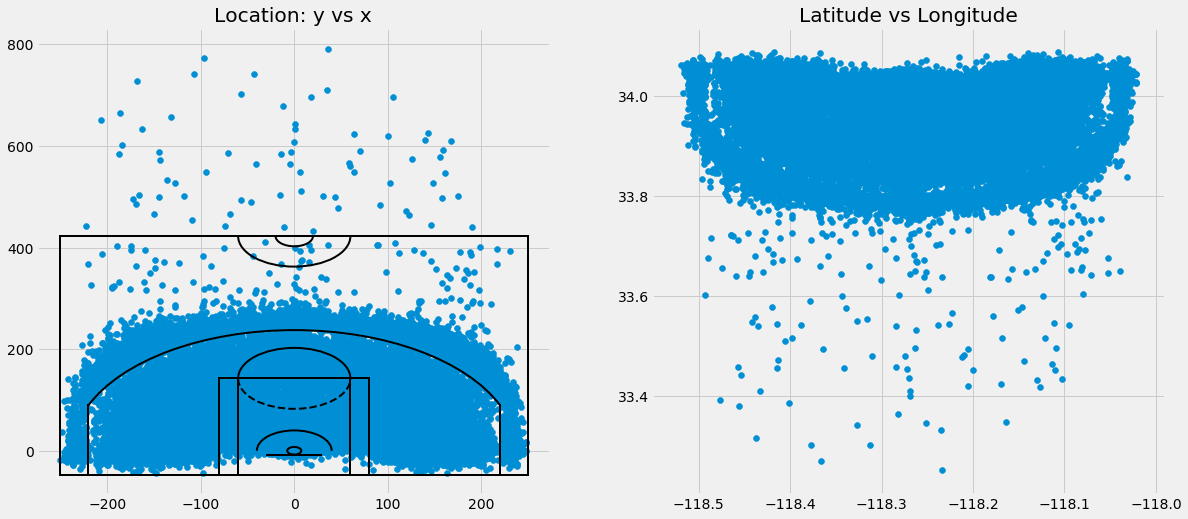

In [135]:
# Plotting loc_x and loc_y
fig = plt.figure(figsize=(18, 8))
fig.add_subplot(1,2,1)
plt.scatter(x=df['loc_x'],y=df['loc_y'])
plt.title("Location: y vs x")
draw_court(outer_lines=True)

# Plotting lat and lon
fig.add_subplot(1,2,2)
plt.scatter(x=df['lon'],y=df['lat'])
plt.title("Latitude vs Longitude")
draw_court(outer_lines=True)

plt.show()

- For visualization purposes, the coordinates given by loc_x and loc_y seem more suitable since the basket is at (0,0) and all the shots are plotted based on their coordinates from there
- Making use of the draw_court function, we can get a clearer idea of where were they made from

### 2.3 Plotting shot accuracy per location

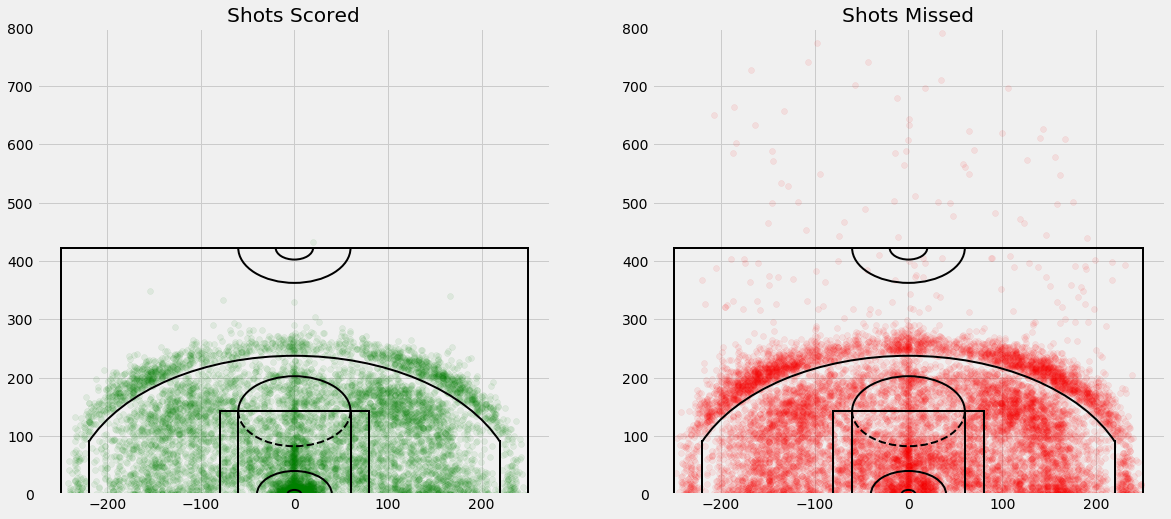

In [136]:
# Plotting shots made per location based in loc_x and loc_y in relation to the court

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.scatter(df.loc[df.shot_made_flag==1, 'loc_x'], df.loc[df.shot_made_flag==1, 'loc_y'], alpha=0.08, c='green')
plt.title('Shots Scored')
plt.ylim(0, 800)
draw_court(outer_lines=True)

# Plotting shots missed per location based in loc_x and loc_y in relation to the court
plt.subplot(1,2,2)
plt.scatter(df.loc[df.shot_made_flag==0, 'loc_x'], df.loc[df.shot_made_flag==0, 'loc_y'], alpha=0.08, c='red')
plt.title('Shots Missed')
plt.ylim(0, 800)
draw_court(outer_lines=True)
plt.show()

- The higher density zones represent where most shots were made from
- There seems to be a higher number of attempts closer to the basket and on the sides of the 3-point line
- The corners and the center of the 3-point mark seem to be weaker spots where less shots are made and converted

### 2.4 Plotting shot accuracy per distance

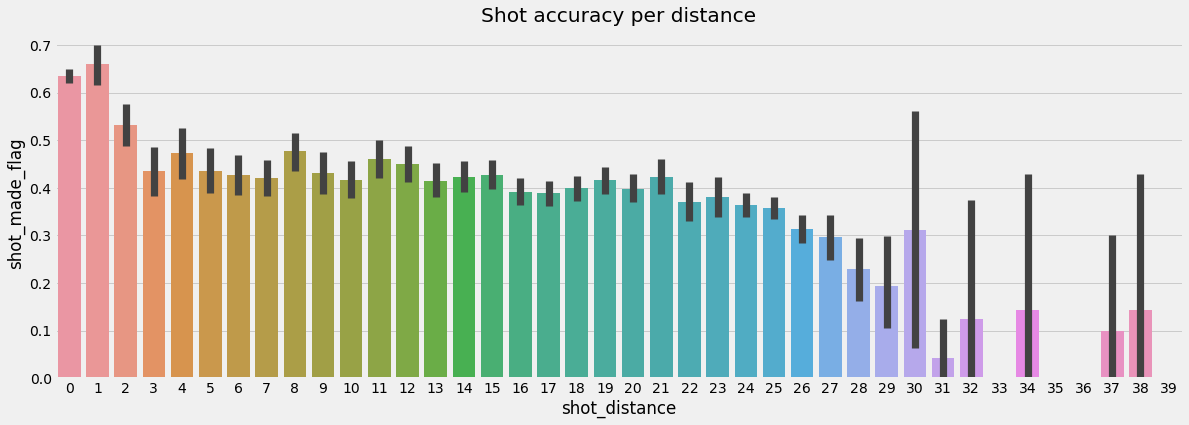

In [137]:
# Shooting accuracy with shot distance

# seaborn barplot computes the mean of the shot_made_flag automatically
# lines compute a confidence interval around the estimate, which is plotted using error bars

# The NBA 3-point line is (mostly) 23.75 feet away from the basket

fig = plt.figure(figsize=(18, 6))
sns.barplot('shot_distance', 'shot_made_flag', data=df[df['shot_distance']<40])
plt.title('Shot accuracy per distance')
plt.show()

- As it would be expected, the closer to the basket, the higher is his shot accuracy
- Still, it's quite impressive how his accuracy is above 40% up to 15feet and above 30% up to 27feet


In [138]:
made_2pt = df[(df['shot_made_flag']==1) & (df['shot_type']=='2PT Field Goal')].sum()['shot_made_flag']
made_3pt = df[(df['shot_made_flag']==1) & (df['shot_type']=='3PT Field Goal')].sum()['shot_made_flag']

all_2pt = df[df['shot_type']=='2PT Field Goal'].count()['shot_made_flag']
all_3pt = df[df['shot_type']=='3PT Field Goal'].count()['shot_made_flag']

print('- His average 2PT Field Goal efficiency throughout his career was', round((made_2pt/all_2pt)*100,2))
print('- His average 3PT Field Goal efficiency throughout his career was', round((made_3pt/all_3pt)*100,2))

- His average 2PT Field Goal efficiency throughout his career was 47.73
- His average 3PT Field Goal efficiency throughout his career was 32.93


### 2.5 Plotting shots per type, season, period and zone

In [139]:
df.season[:4]
df['season'] = df['season'].apply(lambda x: x[:4])

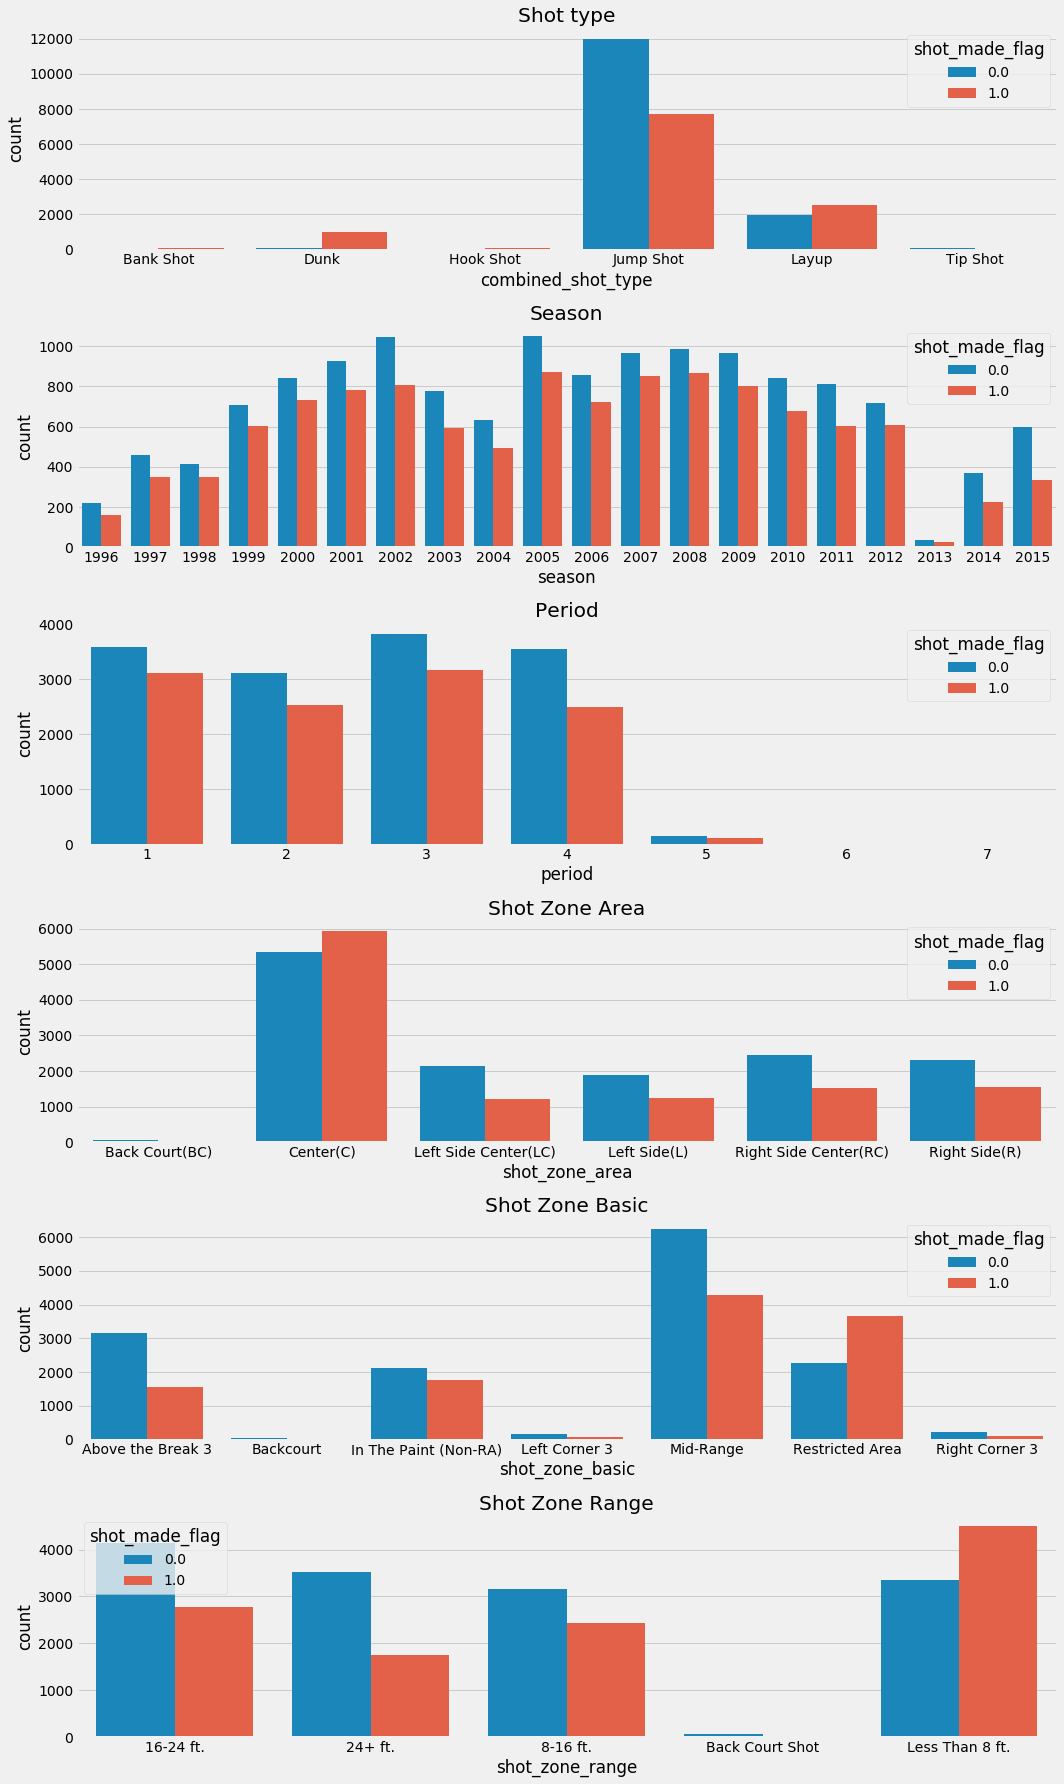

In [140]:
f, axarr = plt.subplots(6, figsize=(15, 25))

sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=df, ax=axarr[0])
sns.countplot(x="season", hue="shot_made_flag", data=df, ax=axarr[1])
sns.countplot(x="period", hue="shot_made_flag", data=df, ax=axarr[2])
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=df, ax=axarr[3])
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=df, ax=axarr[4])
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=df, ax=axarr[5])

axarr[0].set_title('Shot type')
axarr[1].set_title('Season')
axarr[2].set_title('Period')
axarr[3].set_title('Shot Zone Area')
axarr[4].set_title('Shot Zone Basic')
axarr[5].set_title('Shot Zone Range')

plt.tight_layout()
plt.show()

- His preferred shot type is clearly the Jump Shot
- His best seasons were 2000-2002 and 2007-2009 in terms of shots scored - which match the years when LAL won 
- Kobe was most effective in the 1st and 3rd periods
- The center, mid-range, less than 8-feet region was where he used to make most of his buckets
- During the 2013 season, Bryant ruptured his left Achilles' tendon and didn't play for most of the season

### 2.6 Plotting shot accuracy per type and zone

In [141]:
def shot_accuracy(col):
    return df.groupby([col]).mean()['shot_made_flag'].sort_values(ascending=False)

- His peak accuracy happened during overtime and in the first and third quarters of the game
- The highest accuracy is the one attributed to the shots that are less than 8 ft. away, from a center position

Text(0.5, 1.0, 'Shot Zone Range')

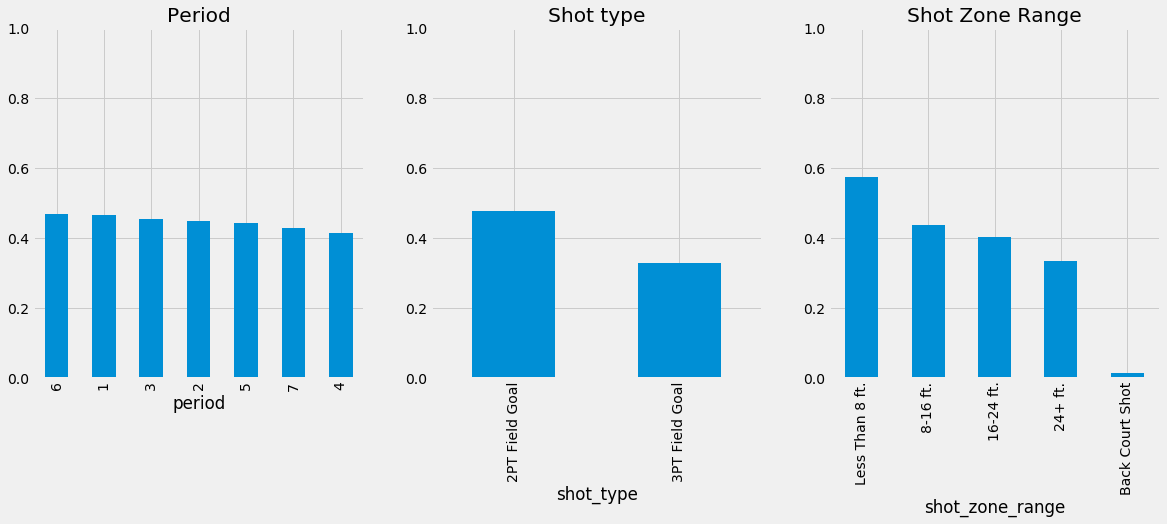

In [142]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

shot_accuracy('period').plot.bar(ylim=(0,1), ax=axes[0])
shot_accuracy('shot_type').plot.bar(ylim=(0,1), ax=axes[1])
shot_accuracy('shot_zone_range').plot.bar(ylim=(0,1), ax=axes[2])

axes[0].set_title('Period')
axes[1].set_title('Shot type')
axes[2].set_title('Shot Zone Range')

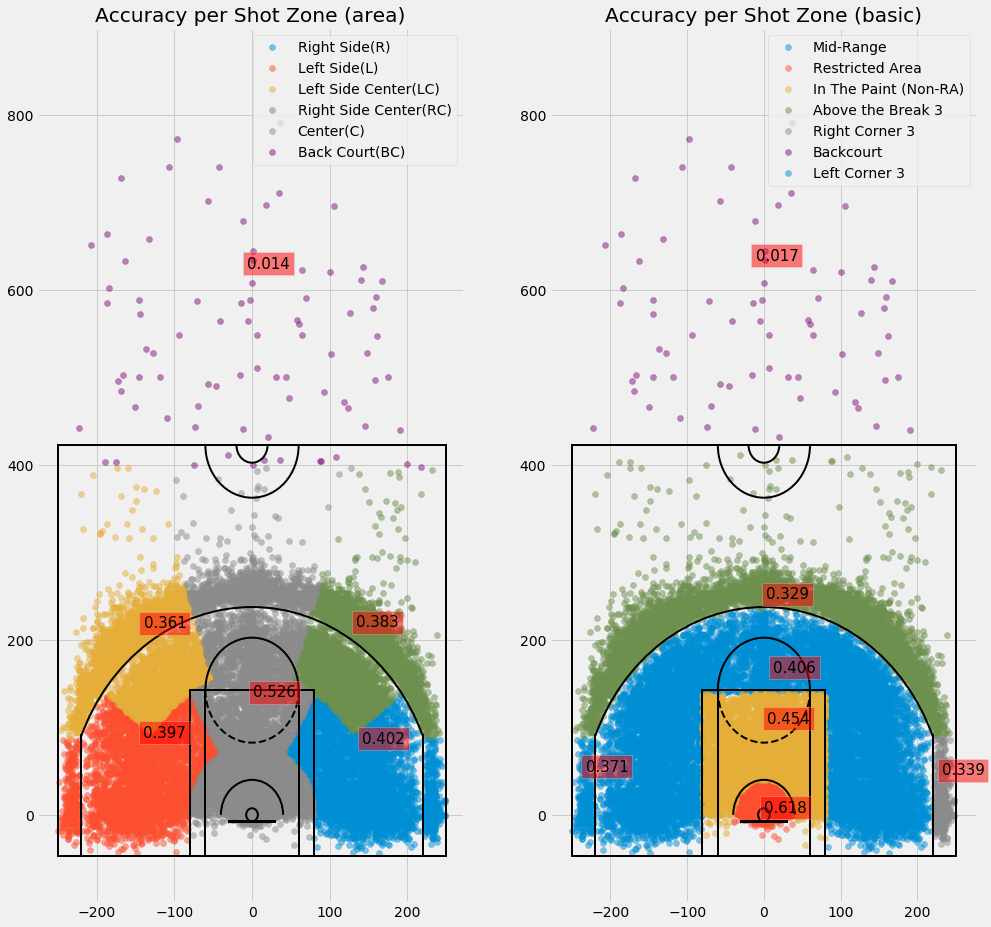

In [143]:
plt.subplots(1, 3, figsize=(15, 15), sharey=True)

zone_mean = df.groupby('shot_zone_area')['shot_made_flag'].mean()
plt.subplot(1,2,1)

for i, area in enumerate(df['shot_zone_area'].unique()):
        zone = df.loc[(df['shot_zone_area']==area)]
        plt.scatter(zone.loc_x, zone.loc_y,alpha=0.5)
        plt.text(zone.loc_x.mean(), zone.loc_y.quantile(0.80), round(zone_mean[area],3),size=15, bbox=dict(facecolor='red', alpha=0.5))
        plt.ylim(-100, 900)
plt.legend(df['shot_zone_area'].unique())
draw_court(outer_lines=True)
plt.title('Accuracy per Shot Zone (area)')

#####

basic_mean = df.groupby('shot_zone_basic')['shot_made_flag'].mean()
plt.subplot(1,2,2)
for i, area in enumerate(df['shot_zone_basic'].unique()):
        basic = df.loc[(df['shot_zone_basic']==area)]
        plt.scatter(basic.loc_x, basic.loc_y,alpha=0.5)
        plt.text(basic.loc_x.mean(), basic.loc_y.quantile(0.80), round(basic_mean[area],3),size=15, bbox=dict(facecolor='red', alpha=0.5))
        plt.ylim(-100, 900)
plt.legend(df['shot_zone_basic'].unique())
plt.title('Accuracy per Shot Zone (basic)')
draw_court(outer_lines=True)
plt.show()

### 2.7 Plotting accuracy across his career 

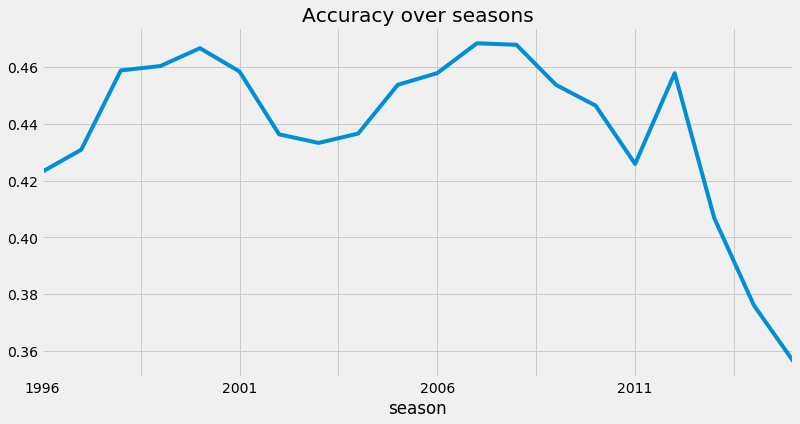

In [144]:
season_acc = df['shot_made_flag'].groupby(df['season']).mean()
season_acc.plot(figsize=(12, 6), title='Accuracy over seasons')

- Given his 20 year career, the plot pictures quite well the peak stage of his performance at the NBA 
- The spike close to the end of his career was during his comeback after the 2013 injury

# 3. Correlation Analysis

### 3.1 Heatmap of all the variables

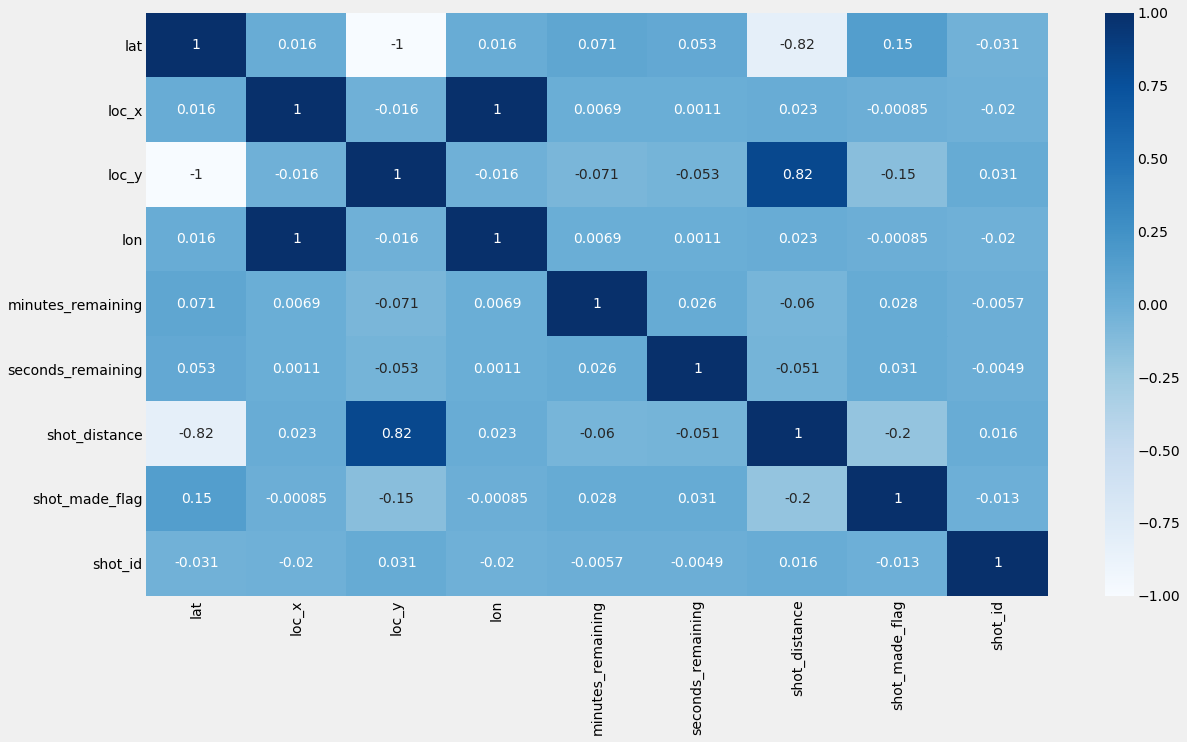

In [145]:
plt.figure(figsize=(18,10))
sns.heatmap(df.corr(), annot=True, center=0, cmap='Blues')

- game_event_id & period
- game_id & playoffs
- lat & shot_distance
- loc_y & shot_distance
- minutes_remaining & game_event_id

`w/ shot_made_flag`
- shot_made_flag & lat 
- shot_made_flag & loc_y
- shot_made_flag & shot_distance : -0.2

# Correlation Heatmap


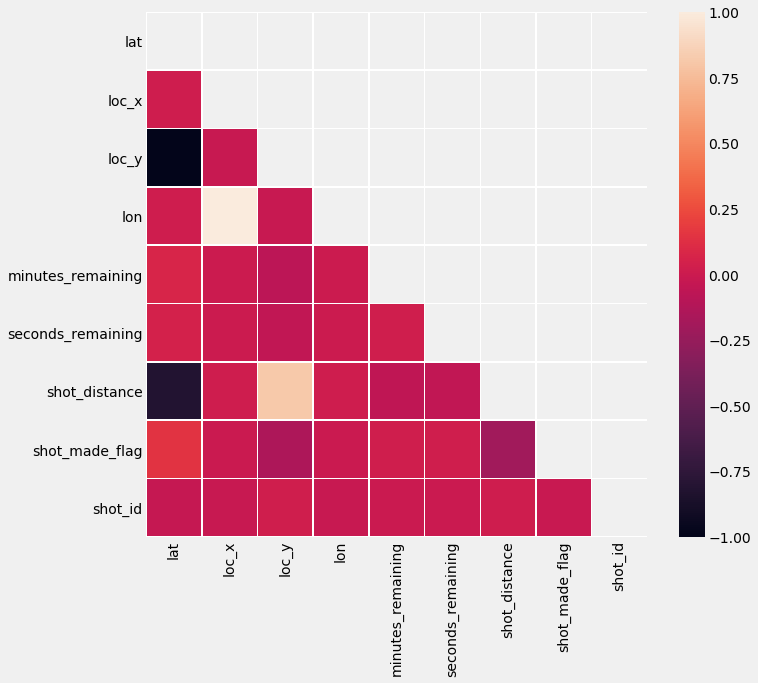

In [146]:
# Compute the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, linewidths=0.5,)
plt.show()

In [147]:
from scipy.stats import pearsonr

print(f'Correlation lon/loc_x: {pearsonr(df.lat, df.loc_y)[0]}')
print(f'Correlation lon/loc_x: {pearsonr(df.lon, df.loc_x)[0]}')

Correlation lon/loc_x: -1.0
Correlation lon/loc_x: 1.0


- The variables lon/loc_x and lat/loc_y are completed correlated (-1) which means they can be deleted from the model in order to avoid introducing redundance

In [148]:
df.describe(include=['object', 'category'])

,action_type,combined_shot_type,game_event_id,game_id,period,playoffs,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,620,1559,7,2,20,2,6,7,5,1,1,1559,74,33
top,Jump Shot,Jump Shot,2,21501228,3,0,2005,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,132,50,8296,26198,2318,24271,13455,12625,9398,30697,30697,50,1020,1978


In [149]:
df.drop(axis=1, inplace=True, columns = ['team_id',        # only 1 value - LAL
                                         'team_name',      # only 1 value - Kobe only played for LA Lakers
                                         'matchup',        # same info as column opponent (LAL @ SAS = SAS)
                                         'game_event_id',  # adds no value to the analysis
                                         'game_id'])        # adds no value to the analysis                                

In [150]:
# not relevant since we won't be interpretating the dataset as a time-series
df.drop(axis=1, inplace=True, columns = ['game_date', 'season'])

In [151]:
# seconds_remaining and minutes_remaining refer to the same variable (time)

df['remaining_time'] = 60*df['seconds_remaining'] + df['minutes_remaining']
df.drop('minutes_remaining', axis=1, inplace=True)
df.drop('seconds_remaining', axis=1, inplace=True)

In [152]:
df.set_index('shot_id', inplace=True)

In [153]:
df.head()

,action_type,combined_shot_type,lat,loc_x,loc_y,lon,period,playoffs,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,remaining_time
shot_id,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,33.9723,167,72,-118.1028,1,0,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,POR,1630
2,Jump Shot,Jump Shot,34.0443,-157,0,-118.4268,1,0,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,1330
3,Jump Shot,Jump Shot,33.9093,-101,135,-118.3708,1,0,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,POR,2707
4,Jump Shot,Jump Shot,33.8693,138,175,-118.1318,1,0,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,POR,3126
5,Driving Dunk Shot,Dunk,34.0443,0,0,-118.2698,2,0,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,1146


### 3.2 One hot encoding

### Categorical variables

In [154]:
# for loop

# df['period'] = df['period'].astype('category') 
# df['season'] = df['season'].astype('category') 
# df['team_id'] = df['team_id'].astype('category')
# df['game_id'] = df['game_id'].astype('category')
# df['opponent'] = df['opponent'].astype('category')
# df['playoffs'] = df['playoffs'].astype('category')
# df['shot_type'] = df['shot_type'].astype('category')
# df['action_type'] = df['action_type'].astype('category')
# df['game_event_id'] = df['game_event_id'].astype('category')
# df['shot_zone_area'] = df['shot_zone_area'].astype('category')
# df['shot_zone_basic'] = df['shot_zone_basic'].astype('category')
# df['shot_zone_range'] = df['shot_zone_range'].astype('category')
# df['combined_shot_type'] = df['combined_shot_type'].astype('category')

In [155]:
categorical_cols = df.select_dtypes(include=['object', 'category'])
categorical_cols

,action_type,combined_shot_type,period,playoffs,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent
shot_id,,,,,,,,,
1,Jump Shot,Jump Shot,1,0,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,POR
2,Jump Shot,Jump Shot,1,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR
3,Jump Shot,Jump Shot,1,0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,POR
4,Jump Shot,Jump Shot,1,0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,POR
5,Driving Dunk Shot,Dunk,2,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR
...,...,...,...,...,...,...,...,...,...
30693,Jump Shot,Jump Shot,4,1,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,IND
30694,Tip Shot,Tip Shot,4,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,IND
30695,Running Jump Shot,Jump Shot,4,1,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,IND


In [156]:
# Creating dummies with a df with numerical variables only (0/1) and adding the column name as prefix 

for cat in categorical_cols:
    dummies = pd.get_dummies(df[cat])
    dummies = dummies.add_prefix("{}#".format(cat))
    df = df.join(dummies)

In [157]:
df.head()


,action_type,combined_shot_type,lat,loc_x,loc_y,lon,period,playoffs,shot_distance,shot_made_flag,shot_type,shot_zone_area,...,opponent#OKC,opponent#ORL,opponent#PHI,opponent#PHX,opponent#POR,opponent#SAC,opponent#SAS,opponent#SEA,opponent#TOR,opponent#UTA,opponent#VAN,opponent#WAS
shot_id,,,,,,,,,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,33.9723,167,72,-118.1028,1,0,18,NaN,2PT Field Goal,Right Side(R),...,0,0,0,0,1,0,0,0,0,0,0,0
2,Jump Shot,Jump Shot,34.0443,-157,0,-118.4268,1,0,15,0.0,2PT Field Goal,Left Side(L),...,0,0,0,0,1,0,0,0,0,0,0,0
3,Jump Shot,Jump Shot,33.9093,-101,135,-118.3708,1,0,16,1.0,2PT Field Goal,Left Side Center(LC),...,0,0,0,0,1,0,0,0,0,0,0,0
4,Jump Shot,Jump Shot,33.8693,138,175,-118.1318,1,0,22,0.0,2PT Field Goal,Right Side Center(RC),...,0,0,0,0,1,0,0,0,0,0,0,0
5,Driving Dunk Shot,Dunk,34.0443,0,0,-118.2698,2,0,0,1.0,2PT Field Goal,Center(C),...,0,0,0,0,1,0,0,0,0,0,0,0


### `WIP - Work in Progress` 

### 3.3 Dimensionality Reduction and Logistic Regression 

In [158]:
# Splitting data from the target class we want to predict (shot_made_flag) into train-test 

data = df[~df.shot_made_flag.isna()] 
submit = df[df.shot_made_flag.isna()]

In [159]:
# Creating training set

from sklearn.model_selection import train_test_split

# Splitting data into train-test
data = df[~df.shot_made_flag.isna()]
submit = df[df.shot_made_flag.isna()]

X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'shot_made_flag'], 
                                                    data.shot_made_flag, test_size=0.2, random_state=0, 
                                                    stratify=data.shot_made_flag)



### Recursive Feature Elimination

In [160]:
df["shot_type"] = df["shot_type"].astype('category')
df["action_type"] = df["action_type"].astype('category')

In [161]:
from sklearn.feature_selection import RFE

# Dimensionality Reduction means reducing the dimensions of the feature space 
# It is used to find the “latent” features in your data 

# Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and 
# choose either the best or worst performing feature, setting the feature aside and then repeating the process 
# with the rest of the features. 
# The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

# Reduction of dimensions is needed when there are far too many features in a dataset, 
# making it hard to  distinguish between the important ones that are relevant to the output 
# and the redundant or not-so important ones.

In [162]:
# StandardScaler() standardize features by removing the mean and scaling to unit variance

from sklearn.preprocessing import StandardScaler, MinMaxScaler


sc = MinMaxScaler()

# X_train_sc = pd.DataFrame(sc.fit_transform(X_train.values), 
#                           index=X_train.index, 
#                           columns=X_train.columns)
# X_test_sc = pd.DataFrame(sc.transform(X_test.values), 
#                           index=X_test.index, 
#                           columns=X_test.columns)

### Implementing the model

In [163]:
from sklearn.linear_model import LogisticRegression

# logreg = LogisticRegression( )
# rfe = RFE(logreg, )
# rfe = rfe.fit()
# print(rfe.support_)
# print(rfe.ranking_)

### Logistic Regression Model Fitting

In [164]:
import statsmodels.api as sm

# logit_model=sm.Logit(y,X)

# result=logit_model.fit()

### 4. Compute precision, recall, F-measure and support

In [165]:
# y_pred = logreg.predict(X_test)

# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp 
# the number of false positives

# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the 
# number of false negatives. 

# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, 
# where an F-beta score reaches its best value at 1

# The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means 
# recall and precision are equally important.

from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))

### 3.4 Linear Discriminant Analysis

In [166]:
from sklearn.linear_model import LogisticRegression

# # Create the RFE object and compute a cross-validated score.
# ranker = LogisticRegression()

# # The "accuracy" scoring is proportional to the number of correct classifications
# rfecv = RFECV(estimator=ranker, step=1, cv=StratifiedKFold(2),
#               scoring='accuracy')
# rfecv.fit(X_train_sc, y_train)

# print("Optimal number of features based on Logistic Regression : %d" % rfecv.n_features_)

# # Plot number of features VS. cross-validation scores
# plt.figure(figsize=(13, 6.5))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

In [167]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import  RFECV
from sklearn.model_selection import StratifiedKFold

In [168]:
# # Linear Discriminant Analysis is a supervised classification technique which takes labels into consideration

# # The first step is to calculate the separability between different classes(i.e the distance between the mean 
# # of different classes) also called as between-class variance

# ranker = LinearDiscriminantAnalysis()

# # RFCEV: Recursive Feature Eliminatin and Cross Vlidated
# # Feature ranking with recursive feature elimination and cross-validated selection of the best number of features


# rfecv = RFECV(estimator=ranker, step=1, cv=StratifiedKFold(2), scoring='neg_log_loss')
# rfecv.fit(X_train_sc, y_train)

# print('Optimal number of features based on LDA :', rfecv.n_features_)

# # Plot number of features VS. cross-validation scores
# plt.figure(figsize=(13, 6.5))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()